# Notebook to analyze the data from AGNs catalogs

We want to analyze multiwavelength data from several AGNs.  
In order to do that, we have compiled data from $18023$ sources.  
They have been retrieved from the review from **Inayosi et al., 2020**, 
the `COSMOS` catalog  
(`VLA-COSMOS 3 GHz Large Project`; **Smolčić et al. 2017**), and from  
the Million Quasar Catalog (`Milliquas`; **Flesch, 2019**) combined with the  
cross-matching between `SDSS QUASAR DR12` catalog and `FIRST` observations.

In this way, we select sources with observations in radio frequencies.

---

## Python setup

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
# from astropy.io import fits
# from astropy.table import Table
# from astropy.table import Column
# from astropy.table import MaskedColumn
# from astropy.table import hstack
# from astropy.table import vstack
# from astropy.table import join
# from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
# from astroquery.simbad import Simbad
# from astroquery.ned import Ned
import getpass
import progressbar
import pandas as pd
from pandas.plotting import scatter_matrix
import re

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [2]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [3]:
alpha_used  = alpha_butl

We define the cosmological properties to calculate luminosity distances and other quantities.

In [4]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
def lum_from_flux(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

---

## Reading data

In [6]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

We import our data using the `pandas` package.  

It is important to keep in mind that columns with keys starting with `Flux Density...` are in `Jy`.  
All the other values, are expressed in `mJy`.

Columns with uncertainties (`NED Uncertainty...`) have been saved as strings, to preserve possible upper limits.

In [7]:
large_catalog_df = pd.read_hdf(cat_path + 'large_cat_simbad_inayoshi_ned.h5', 'df')

Data could be also converted into `astropy` Tables.

In [8]:
# large_catalog_tab = Table.from_pandas(large_catalog_df)

It is possible to save column names into a plain text file to keep track of them.

In [9]:
# np.savetxt('column_names_flx.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')

From the querying process, some columns have the same identifier.  
In those cases, the suffix `_x` or `_y` has been added (`_x` for `simbad` data, and `_y` for `Ned` photometry).
One example is shown below.

In [10]:
# large_catalog_df.loc[90:100, ['MAIN_ID_x', 'MAIN_ID_y']]

---

## Organize data

Separate data into different arrays for calculations

Repeated keywords are: `MAIN_ID_x`, `MAIN_ID_y`, `COORD_x`, and `COORD_y`

The following redshift column comes from `SDSS` with the highest quality flag selected.

In [11]:
redshift    = large_catalog_df['Z_OWN']
redshift_e  = large_catalog_df['Z_OWN_ERR']
L_20cm      = large_catalog_df['L_20CM']
L_20cm_e    = large_catalog_df['L_20CM_ERR']
L_20cm_up_l = large_catalog_df['L_20CM_UP_LIM']

We can calculate luminosities from fluxes.

In this case, we first select the columns with fluxes in a numerical format  
(with this all error columns are discarded for the moment).

In [12]:
numeric_col_names = large_catalog_df.select_dtypes('number').columns.drop(['INDEX', 'RA_d', 'DEC_d', 'Z_VALUE', 'FLUX_ERROR_B',\
                                                                           'Z_OWN_ERR', 'L_20CM', 'L_20CM_ERR', 'L_250GHZ', 'L_250GHZ_ERR',\
                                                                           'F_20CM_ERR', 'F_250GHZ_ERR', 'MASS_1450', 'FLUX_ERROR_V',\
                                                                           'FLUX_ERROR_R', 'FLUX_ERROR_I','FLUX_ERROR_J',\
                                                                           'FLUX_ERROR_K', 'Z_OWN'])
#numeric_col_names = large_catalog_df.select_dtypes('number').columns.drop(['INDEX', 'RA_d', 'DEC_d', 'Z_VALUE', 'D_LUM', 'FLUX_ERROR_B',\
#                                                                           'Z_OWN_ERR', 'L_20CM', 'L_20CM_ERR', 'L_250GHZ', 'L_250GHZ_ERR',\
#                                                                           'F_20CM_ERR', 'F_250GHZ_ERR', 'MASS_1450', 'FLUX_ERROR_V',\
#                                                                           'FLUX_ERROR_R', 'FLUX_ERROR_I','FLUX_ERROR_J',\
#                                                                           'FLUX_ERROR_K', 'JOINED_F_14GHZ', 'TEST_14_LUM',\
#                                                                           'Z_OWN'])

We create a new `pandas` `DataFrame` object to contain our luminosities,  
and we calculate them taking into account the difference in units for some of the  
columns with fluxes.

In [13]:
lums_catalog_df                       = pd.DataFrame()

In [14]:
for col_name in numeric_col_names:
    if 'F_' in col_name:
        lum_col_name                  = col_name.replace('F_', 'LUMINOSITY_')
        lums_catalog_df[lum_col_name] = lum_from_flux(large_catalog_df[col_name], redshift)
    if 'FLUX_' in col_name:
        lum_col_name                  = col_name.replace('FLUX_', 'LUMINOSITY_')
        lums_catalog_df[lum_col_name] = lum_from_flux(large_catalog_df[col_name], redshift)
    if 'Flux Density' in col_name:
        lum_col_name                  = col_name.replace('Flux Density', 'Luminosity')
        lums_catalog_df[lum_col_name] = lum_from_flux(large_catalog_df[col_name] * 1e3, redshift) 

For future use and reference, we can add new columns to the original catalog. 

One such column contains luminosity distances calculated from redshift values.

In [15]:
large_catalog_df['D_LUM']           = cosmo.luminosity_distance(large_catalog_df['Z_OWN']).to(u.m).value

Our catalog contains several columns with observations in very similar  
frequencies and configurations.  
As a way to gather them, we can create a new column with the **average**  
(in `mJy`) of all the $1.4$ GHz fluxes. 

In [16]:
large_catalog_df['F_14GHZ_average'] = (large_catalog_df[['Flux Density 1.4GHz', 'Flux Density 1.40 GHz',\
                                'Flux Density 1.4 GHz', 'Flux Density 1420.5 MHz',\
                                'Flux Density 1.42 GHz', 'Flux Density 1425 MHz',\
                                'Flux Density 1410 MHz', 'Flux Density 1.4 GHz VLA B-array']].mean(axis=1) * 1e3 + large_catalog_df['F_20CM']) / 2

From this new column, luminosities can be obtained and added to the recently created table.

In [17]:
# joined_lum_14GHz = lum_from_flux(large_catalog_df['JOINED_F_14GHZ'], redshift)
lums_catalog_df['LUMINOSITY_14GHZ_average'] = lum_from_flux(large_catalog_df['F_14GHZ_average'], redshift)

As before, we can create a file to save the names of this new table with luminosities

In [18]:
# np.savetxt('column_names_lum.txt', lums_catalog_df.columns, fmt='%s', delimiter='\n')

Only for calculation purposes, we can show the luminosity columns with the ($10$) highest number of elements.

In [19]:
stats_lums  = pd.DataFrame(lums_catalog_df.describe().loc['count'])
counts_lums = stats_lums.sort_values('count', ascending=False)
counts_lums[:10]

,count
LUMINOSITY_20CM,17957.0
Luminosity W1,10393.0
Luminosity i,10174.0
Luminosity z,10075.0
Luminosity r,10066.0
Luminosity g,10057.0
Luminosity u,10021.0
Luminosity W2,9800.0
LUMINOSITY_V,9166.0
LUMINOSITY_B,9062.0


---

## Plot initial values

We create an initial plot of $1.4$ GHz vs. redshift ($z$) for our sources.

Fix fluxes are added for ease of comprehension.

In [20]:
z_range        = np.arange(0, 10.2, 0.25)  # array to be used in other instances
lum_dist_range = cosmo.luminosity_distance(z_range).to(u.m).value  # in m

In [21]:
lum_FIRST      = 4 * np.pi * lum_dist_range**2 * 1e-3  * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_50uJy      = 4 * np.pi * lum_dist_range**2 * 50e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_20uJy      = 4 * np.pi * lum_dist_range**2 * 20e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_10uJy      = 4 * np.pi * lum_dist_range**2 * 10e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_5uJy       = 4 * np.pi * lum_dist_range**2 * 5e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_1uJy       = 4 * np.pi * lum_dist_range**2 * 1e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)

In [22]:
cmap           = cm.get_cmap('inferno')
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]

In [23]:
pe1            = [mpe.Stroke(linewidth=3, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

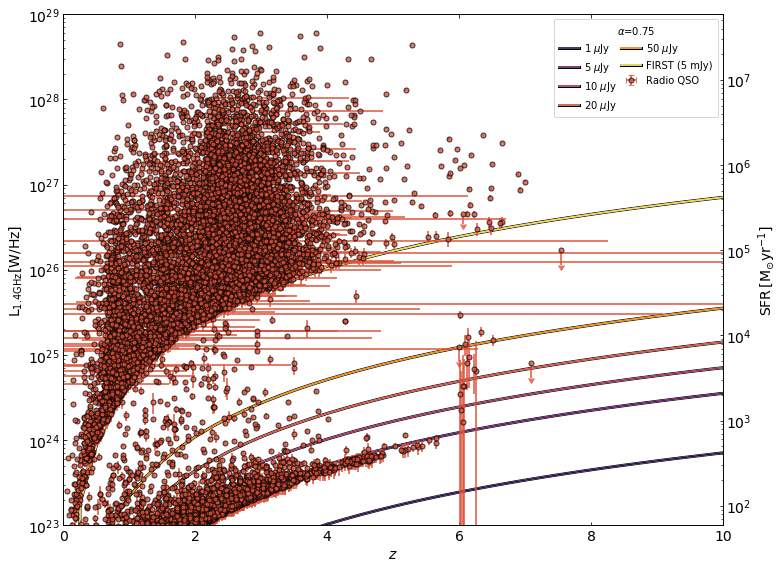

In [24]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.errorbar(redshift, L_20cm, xerr=redshift_e, yerr=L_20cm_e, marker='.', ls='', color=colors[3], markersize=10, zorder=7, alpha=0.75, uplims=L_20cm_up_l, elinewidth=2, mec='k', label='Radio QSO')

#ax1.errorbar(high_z_zs[filter_250GHz], lum_250_new_alpha_rescale[filter_250GHz], yerr=lum_250_new_alpha_rescale_e[filter_250GHz], marker='P', ls='', color=colors[4], markersize=10, zorder=7, alpha=0.65, uplims=high_z_up_lim[filter_250GHz], elinewidth=2, mec='k', label='mm QSO')

ax1.plot(z_range, lum_1uJy, label='1 $\mu$Jy', color=colors[0], path_effects=pe1)
ax1.plot(z_range, lum_5uJy, label='5 $\mu$Jy', color=colors[1], path_effects=pe1)
ax1.plot(z_range, lum_10uJy, label='10 $\mu$Jy', color=colors[2], path_effects=pe1)
ax1.plot(z_range, lum_20uJy, label='20 $\mu$Jy', color=colors[3], path_effects=pe1)
ax1.plot(z_range, lum_50uJy, label='50 $\mu$Jy', color=colors[4], path_effects=pe1)
ax1.plot(z_range, lum_FIRST, label='FIRST (5 mJy)', color=colors[5], path_effects=pe1)
#ax1.plot(z_range, SFR_3000, label='3000M_sun/yr', color=colors[2], path_effects=pe1)
#ax1.fill_between(z_range, SFR_3000 - SFR_3000_e, SFR_3000 + SFR_3000_e, color=colors[2], fc=colors[2], alpha=0.3, zorder=6)
#gradient_fill(z_range, max_pow_sfr_fix + 3 * max_pow_sfr_fix_e, fill_color=colors[4], color=colors[4], label='SFR - fixed M', zorder=5, ax=ax1)
#ax1.plot(z_range, max_pow_sfr_fix, '-', color=colors[4], alpha=0.45)
#gradient_fill(z_range, max_pow_sfr + 3 * max_pow_sfr_e, fill_color=colors[3], color=colors[3], label='SFR - evolv. M', zorder=5, ax=ax1)
#ax1.plot(z_range, max_pow_sfr, '-', color=colors[3], alpha=0.45)
ax1.set_xlabel('$z$', size=14)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_yscale('log')
ax1.set_ylim((1e23, 1e29))
ax1.set_xlim(left=-0.001, right=10)
#ax1.set_xlim(left=5.5, right=8)
ax1.legend(loc=1, title=f'{alp_str}={alpha_used}', ncol=2, labelspacing=0.5, borderpad=0.5, columnspacing=0.5, handletextpad=0.5)


ax2 = ax1.twinx()
ax2.set_ylabel('$\mathrm{SFR}\, [\mathrm{M}_{\odot} \mathrm{yr}^{-1}]$', size=14)
ax2.set_ylim((1e23 * 5.9e-22, 1e29 * 5.9e-22))
ax2.set_yscale('log')
ax2.figure.canvas.draw()

#plt.setp(ax2.get_yticklabels(), visible=False)
ax1.tick_params(which='both',top=True, right=False, direction='in')
ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout(w_pad=0.01)

We can see a very noticeable gap in our source distribution.
From the calculations in **Amarantidis et al., 2019**, we can explain this behavior  
from the selection biases of the different surveys involved in the production of our catalog. 

---

Another option to display the data is using histograms.  
From the selection of one column, we can create a plot.

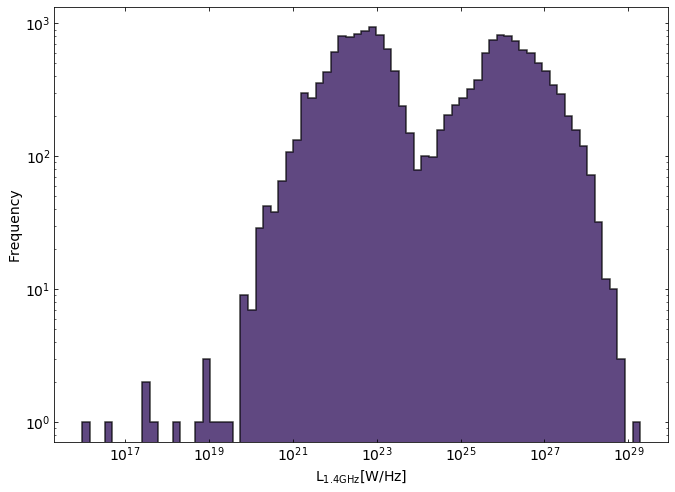

In [25]:
fig    = plt.figure(figsize=(11,8))
ax1    = fig.add_subplot(111)

vmin_L = np.log10(large_catalog_df['L_20CM'].min())
vmax_L = np.log10(large_catalog_df['L_20CM'].max())
bins_L = np.logspace(vmin_L, vmax_L, 75)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_ylabel('$\mathrm{Frequency}$', size=14)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
large_catalog_df['L_20CM'].plot.hist(color=colors[0], alpha=0.75, bins=bins_L, histtype='stepfilled', ec='k', lw=1.5)

We can also select two luminosity columns and plot them. We can color-code them by redshift  
and include histograms for both quantities.

In [26]:
lum_names           = lums_catalog_df.columns

In [27]:
add_histograms_flag = True  # Add histograms to the folowing plot

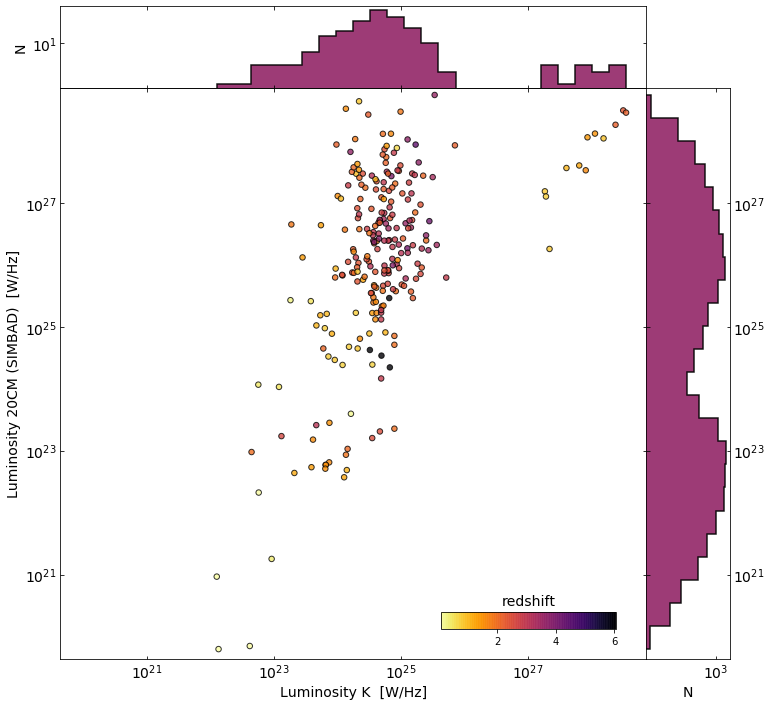

In [28]:
fig        = plt.figure(figsize=(12,12))

if not add_histograms_flag:
    ax1    = fig.add_subplot(111)

if add_histograms_flag:
    ax1    = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2    = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3    = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by number
# col_a = lum_names[0]
# col_b = lum_names[23]

# Select columns by name
col_a       = "Luminosity K"
col_b       = "LUMINOSITY_20CM"

# Obtain luminosities and the cross-match between them
lum_a       = lums_catalog_df[col_a]
lum_b       = lums_catalog_df[col_b]
common_vals = np.multiply(lum_a, lum_b)

# Create log bins for log-scale histograms
min_val     = np.nanmin([lum_a[np.isfinite(common_vals)].min(), lum_b[np.isfinite(common_vals)].min()])
max_val     = np.nanmax([lum_b[np.isfinite(common_vals)].max(), lum_b[np.isfinite(common_vals)].max()])
bins_a      = np.logspace(np.log10(lum_a[np.isfinite(common_vals)].values.min()), np.log10(lum_a[np.isfinite(common_vals)].values.max()), 25)
bins_b      = np.logspace(np.log10(lum_b[np.isfinite(common_vals)].values.min()), np.log10(lum_b[np.isfinite(common_vals)].values.max()), 25)

ax1.set_yscale('log')
ax1.set_xscale('log')

# Format axis names and limits
if 'LUMINOSITY_' in col_a:
    col_a   = col_a.replace('LUMINOSITY_', 'Luminosity ') + ' (SIMBAD)'
if 'LUMINOSITY_' in col_b:
    col_b   = col_b.replace('LUMINOSITY_', 'Luminosity ') + ' (SIMBAD)'
ax1.set_xlabel(col_a + '  [W/Hz]', size=14)
ax1.set_ylabel(col_b + '  [W/Hz]', size=14)
ax1.set_ylim(min_val*0.7, max_val*1.3)
ax1.set_xlim(min_val*0.7, max_val*1.3)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)

sc          = ax1.scatter(lum_a, lum_b, c=redshift, cmap='inferno_r', s=30, alpha=0.80, edgecolor='black')

# Create colorbar and plot it
cbaxes      = inset_axes(ax1, width="30%", height="3%", loc=4, borderpad=3) 
clb         = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
# clb.set_label('redshift', size=14)
clb.ax.set_title('redshift', size=14)

ax1.set_aspect('auto', share=False, adjustable='box')

if add_histograms_flag:
    # Plot vertical histogram
    hist(lum_b.values, bins=bins_b, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.9, color=dark_color, ec='k', lw=1.5, hatch='')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('N', size=14)
    
    # Plot horizontal histogram
    hist(lum_a.values, bins=bins_a, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.9, color=dark_color, ec='k', lw=1.5, hatch='')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylabel('N', size=14)
    
    # Modify ticks
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax3.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)
    ax3.tick_params(which='both',top=True, right=True, direction='in')
    
    plt.subplots_adjust(wspace=0.0, hspace=0.0)

---

# Obtain most highly correlated quantities

Make use of tools from `pandas` to calculate correlations between  
the luminosity columns and find the highest values.  
Pandas default behavior calculates the Pearson correlation coefficient (Kendall Tau and Spearman coefficients are also available).

We can choose how many elements (sources) can be used for calculations. In our case,  
we want to use all of them.

It is also possible to avoid correlation calculations for columns with too few  
elements. The variable `min_elements` has been set to $20$ to this end.

In [29]:
num_of_rows    = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols    = 534    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements   = 20
# corr           = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr           = lums_catalog_df.loc[:num_of_rows].corr(min_periods=20)
corr_abs       = corr.abs()

In the following code block, the names of the pairs of columns with the  
highest correlations (and their values) are retrieved.

In [30]:
cols_corr      = (corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

It is recommended to drop (not using) columns with correlation values too close to one  
($1.0$) as they do not add new information to the analysis. The variable `corr_thresh` will  
limit the correlation values which will be discarded.

The variable `num_of_corr` selects the number of high correlation pairs of columns we want to analyze at a time.  
This is purely for visualization purposes.

In [31]:
corr_thresh    = 0.80  # We want pairs with correlations below this value
num_of_corr    = 20    # How many high correlations we want to analyze at a time

In [32]:
arr_cols       = np.array([np.array(row) for row in cols_corr.keys()[cols_corr<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr = np.unique(np.concatenate((arr_cols[:, 0], arr_cols[:, 1])))  # Array with individual column names from highest correlations

In [33]:
np.shape(cols_high_corr)

(29,)

We can show a sample of the highly correlated pairs of columns.

In [34]:
cols_corr[cols_corr<corr_thresh][:num_of_corr]

Luminosity 4.85 GHz    Luminosity 15 GHz         0.799579
Luminosity H           Luminosity 3.6 microns    0.799128
LUMINOSITY_K           Luminosity K_s            0.799004
Luminosity z           Luminosity B              0.798581
LUMINOSITY_R           Luminosity 250 microns    0.798010
Luminosity J           Luminosity 2700 MHz       0.797879
Luminosity W4          Luminosity R              0.797848
LUMINOSITY_I           Luminosity 500 microns    0.797550
Luminosity 70 microns  Luminosity F814W          0.796523
Luminosity 4.85 GHz    Luminosity 1.40 GHz       0.796054
LUMINOSITY_K           Luminosity 70 microns     0.796048
                       Luminosity 5-10 keV       0.796005
LUMINOSITY_J           Luminosity 70 microns     0.795055
Luminosity u           Luminosity 250 microns    0.793926
Luminosity 8.6 GHz     Luminosity 2.3 GHz        0.793919
Luminosity H           Luminosity 24 microns     0.793757
Luminosity J           Luminosity 3.4 microns    0.793683
LUMINOSITY_20C

---

To better understand the correlation values, we can plot a correlation matrix.  
As previously mentioned, only the selected columns will be plotted for ease of reading.
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

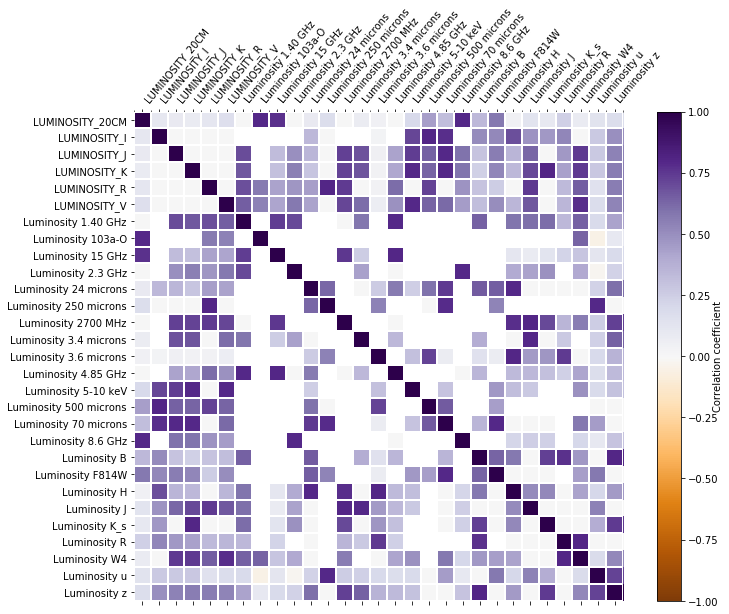

In [35]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask values above correlation threshold (except diagonal values)
arr_corr = corr.loc[cols_high_corr, cols_high_corr]
arr_corr[(arr_corr > corr_thresh) & (arr_corr < 1)] = 0
arr_corr[(arr_corr < -corr_thresh) & (arr_corr > -1)] = 0

cax  = ax1.matshow(arr_corr, cmap='PuOr', vmin=-1, vmax=1)
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(cols_high_corr.tolist()),1)
ax1.set_xticks(np.arange(corr.loc[cols_high_corr, cols_high_corr].shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(corr.loc[cols_high_corr, cols_high_corr].shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr, rotation=50, horizontalalignment='left')
ax1.set_yticklabels(cols_high_corr)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax1.tick_params(which="minor", bottom=False, left=False)

ax1.set_aspect('equal')

Another visualization option considers obtaining a kernel density estimation (`kde`) for the  
distribution of each column (luminosity). The tools of `pandas` allow us to do this.

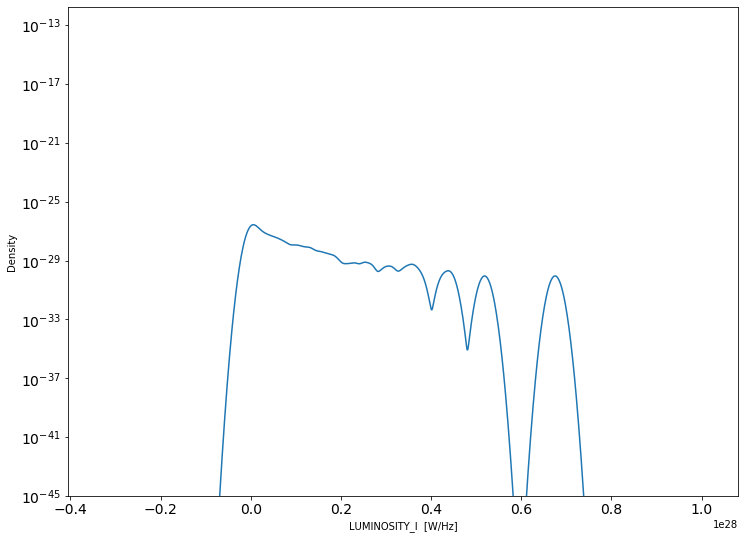

In [36]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

# Choose the column to use (from highly correlated luminosities)
used_col=1

lums_catalog_df[cols_high_corr[used_col]].plot.kde(ax=ax1, fontsize=14, logy=True, ylim=(1e-45, None))
ax1.set_xlabel(cols_high_corr[used_col] + '  [W/Hz]');

This plot can be extended into a scatter matrix which shows individual distributions (`kde`) and pair-wise plots.  
In our case, and given the need of using logarithmic scales for the axes, the plots do not show completely well.  
We leave the code block but without being executed.

In [37]:
# # fig = plt.figure(figsize=(12,9))
# # ax1 = fig.add_subplot(111)

# axl = scatter_matrix(lums_catalog_df[cols_high_corr], alpha=0.2, diagonal='kde', figsize=(12,9))
# 
# for i, axs in enumerate(axl):
#     for j, ax in enumerate(axs):
#         ax.set_xscale('symlog')
#         ax.set_yscale('symlog')